In [1]:
import json
import os
import glob
import math

from tqdm import tqdm
from PIL import Image as PILImage

# src는 커스텀 전 데이터의 경로
# dest는 커스텀 후 이동할 데이터의 경로

### PM : 13 ~ 19 -> 오토바이 0
### PM : 20 ~ 27 -> 자전거 1
### PM : 28 ~ 39 -> 킥보드 2

'''save_img_path, save_label_path 경로 끝에 '/' 붙여야 함 '''

# number, img_path, label_path, save_img_path, save_label_path
class Custom_dataset(): # 단일 파일 경로를 input으로 받는다.
    
    def __init__(self, number, img_path, label_path, save_img_path, save_label_path): 
        self.number = number
        
        self.img_path = img_path
        self.label_path = label_path
        
        self.img_name = self.img_path.split('\\')[-1].split('.j')[0] # 이미지 파일명 ( 확장자 x )
        self.label_name = self.label_path.split('\\')[-1].split('.j')[0] # json 파일명 ( 확장자 x )
        
        self.save_img_path = save_img_path
        self.save_label_path = save_label_path
        
        self.width = 640 # Yolo v7x가 받는 사이즈로 고정 
        self.height = 640 # Yolo v7x가 받는 사이즈로 고정
                
    # read_json
    def read_json(self):
        if self.img_name == self.label_name:
            converted_annotation = []
            with open (self.label_path, "r") as f:
                data = json.load(f)
                raw_width = float(data['description']['imageWidth'])
                raw_height = float(data['description']['imageHeight'])
                annotation = data['annotations']['PM']
            
            if len(annotation) == 0:
                return None, None, None
            
            elif len(annotation) == 1:
                pmcode = int(annotation[0]['PM_code'])
                bbox = annotation[0]['points']
                
                # convert
                pmcode = self.convert_pmcode(pmcode)
                bbox = self.convert_bbox(bbox, raw_width, raw_height)
                
                converted_annotation.append(pmcode)
                converted_annotation += bbox
                return converted_annotation, pmcode, len(annotation)
            
            elif len(annotation) > 1 :
                for anno in annotation:
                    pmcode = int(anno['PM_code'])
                    bbox = anno['points']
                    # convert
                    pmcode = [self.convert_pmcode(pmcode)]
                    bbox = self.convert_bbox(bbox, raw_width, raw_height)
                    pmcode += bbox # [pmcode, x, y, w,h] 형태의 리스트
                    
                    converted_annotation.append(pmcode)
                return converted_annotation, pmcode[0], len(annotation) # 객체가 몇 개인지의 정보
        else:
            return 0

    def convert_pmcode(self, pmcode):
        if 13 <= pmcode <= 19:
            return 0
        elif 20 <= pmcode <=27:
            return 1
        elif 28 <= pmcode <= 39:
            return 2
        
    def convert_bbox(self, bbox, raw_width, raw_height):
        # 0~1 상대값으로 바꿔야함
        w = bbox[2] / raw_width
        h = bbox[3] / raw_height
        x = (bbox[0] / raw_width) + (w/2) # 좌상단값이 아닌 중앙값
        y = (bbox[1] / raw_height) + (h/2) # 좌상단값이 아닌 중앙값
        
        return [x,y,w,h]
                
    def img_resize(self, save_img_path):
        img = PILImage.open(self.img_path)
        img = img.resize((self.width, self.height), PILImage.BICUBIC)
        img.save(save_img_path)
        return True
                
    def run(self):
        if self.img_name == self.label_name:
            converted_annotation, pmcode, annotation_len = self.read_json()
                
            if pmcode == 0:
                cls = 'motorcycle'
            elif pmcode == 1:
                cls = 'bicycle'
            else:
                cls = 'kickboard'
              
            with open(self.save_label_path + '{}_{}.txt'.format(self.number, cls), "w") as f:
                # 객체가 없을 때
                if annotation_len == 0:
                    print('객체가 없습니다.')
                    return 0
                # 객체가 1개일때  
                elif annotation_len == 1:
                    c = int(converted_annotation[0])
                    x = float(converted_annotation[1])
                    y = float(converted_annotation[2])
                    w = float(converted_annotation[3])
                    h = float(converted_annotation[4])
                    f.write(f'{c} {x} {y} {w} {h}')
                    
                    # resizing 속도를 못 쫒아가서 if문 필요
                    if self.img_resize(self.save_img_path+'{}_{}.jpg'.format(self.number, cls)) == True:
                        print(cls,self.number,'번째 파일 컨버팅 완료되었습니다. 객체 {}개'.format(annotation_len))
                        return 1
                    
           # 객체가 2개 이상일때         
                elif annotation_len > 1: # 객체가 2개 이상일때
                    for row in converted_annotation:
                        c = int(row[0])
                        x = float(row[1])
                        y = float(row[2])
                        w = float(row[3])
                        h = float(row[4])
                        f.write(f'{c} {x} {y} {w} {h}\n')
                    
                    # resizing 속도를 못 쫒아가서 if문 필요
                    if self.img_resize(self.save_img_path+'{}_{}.jpg'.format(self.number, cls)) == True:
                        print(cls,self.number,'번째 파일 컨버팅 완료되었습니다. 객체 {}개'.format(annotation_len))
                        return 1
        else:
            print('이미지 파일과 라벨 파일이 일치하지 않습니다.')
            return 0

In [2]:
number = 0
img_path = 'C:/Users/5788j/Desktop/custom_data/custom/dataset/원천데이터'
label_path = 'C:/Users/5788j/Desktop/custom_data/custom/dataset/라벨링데이터' 
save_img_path = 'C:/Users/5788j/Desktop/custom_data/custom/train/images/'
save_label_path = 'C:/Users/5788j/Desktop/custom_data/custom/train/labels/'

imgs = glob.glob(img_path + '/*')[0]
labels = glob.glob(label_path + '/*')[0]

def testLogic(number, img_path, label_path, save_img_path, save_label_path):
    custom_dataset = Custom_dataset( 
                           number = number, 
                           img_path = img_path, 
                           label_path = label_path, 
                           save_img_path = save_img_path,
                           save_label_path = save_label_path)
    custom_dataset.run()

In [3]:
from tqdm import tqdm
img_path = 'C:/Users/5788j/Desktop/custom_data/custom/dataset/원천데이터'
label_path = 'C:/Users/5788j/Desktop/custom_data/custom/dataset/라벨링데이터' 
save_img_path = 'C:/Users/5788j/Desktop/custom_data/custom/train/images/'
save_label_path = 'C:/Users/5788j/Desktop/custom_data/custom/train/labels/'

imgs = glob.glob(img_path + '/*')
labels = glob.glob(label_path + '/*')

# 멀티프로세싱 argument 생성

for i,(img_path, label_path) in tqdm(enumerate(zip(imgs, labels))):
    testLogic(i, img_path, label_path, save_img_path, save_label_path)

2it [00:00,  7.53it/s]

motorcycle 0 번째 파일 컨버팅 완료되었습니다. 객체 1개
motorcycle 1 번째 파일 컨버팅 완료되었습니다. 객체 1개
motorcycle 2

4it [00:00,  8.87it/s]

 번째 파일 컨버팅 완료되었습니다. 객체 1개
motorcycle 3 번째 파일 컨버팅 완료되었습니다. 객체 1개
motorcycle 4 번째 파일 컨버팅 완료되었습니다. 객체 1개


7it [00:00,  6.93it/s]

motorcycle 5 번째 파일 컨버팅 완료되었습니다. 객체 1개
motorcycle 6 번째 파일 컨버팅 완료되었습니다. 객체 1개


8it [00:01,  6.06it/s]

motorcycle 7 번째 파일 컨버팅 완료되었습니다. 객체 1개


10it [00:01,  5.85it/s]

motorcycle 8 번째 파일 컨버팅 완료되었습니다. 객체 1개
motorcycle 9 번째 파일 컨버팅 완료되었습니다. 객체 1개


12it [00:01,  7.55it/s]

motorcycle 10 번째 파일 컨버팅 완료되었습니다. 객체 2개
motorcycle 11 번째 파일 컨버팅 완료되었습니다. 객체 2개
motorcycle 12 번째 파일 컨버팅 완료되었습니다. 객체 2개


15it [00:01,  9.21it/s]

motorcycle 13 번째 파일 컨버팅 완료되었습니다. 객체 2개
motorcycle 14 번째 파일 컨버팅 완료되었습니다. 객체 2개
motorcycle 15 번째 파일 컨버팅 완료되었습니다. 객체 2개


18it [00:02,  8.66it/s]

motorcycle 16 번째 파일 컨버팅 완료되었습니다. 객체 2개
motorcycle 17 번째 파일 컨버팅 완료되었습니다. 객체 2개


20it [00:02,  8.42it/s]

bicycle 18 번째 파일 컨버팅 완료되었습니다. 객체 3개
bicycle 19 번째 파일 컨버팅 완료되었습니다. 객체 3개


21it [00:02,  6.63it/s]

bicycle 20 번째 파일 컨버팅 완료되었습니다. 객체 3개
bicycle 21 번째 파일 컨버팅 완료되었습니다. 객체 2개


23it [00:03,  6.05it/s]

bicycle 22 번째 파일 컨버팅 완료되었습니다. 객체 3개


25it [00:03,  6.79it/s]

bicycle 23 번째 파일 컨버팅 완료되었습니다. 객체 3개
bicycle 24 번째 파일 컨버팅 완료되었습니다. 객체 3개


27it [00:03,  7.38it/s]

bicycle 25 번째 파일 컨버팅 완료되었습니다. 객체 2개
bicycle 26 번째 파일 컨버팅 완료되었습니다. 객체 2개


29it [00:03,  7.91it/s]

bicycle 27 번째 파일 컨버팅 완료되었습니다. 객체 1개
bicycle 28 번째 파일 컨버팅 완료되었습니다. 객체 1개


31it [00:04,  8.23it/s]

bicycle 29 번째 파일 컨버팅 완료되었습니다. 객체 1개
bicycle 30 번째 파일 컨버팅 완료되었습니다. 객체 1개


33it [00:04,  8.20it/s]

bicycle 31 번째 파일 컨버팅 완료되었습니다. 객체 1개
bicycle 32 번째 파일 컨버팅 완료되었습니다. 객체 1개


34it [00:04,  7.36it/s]

bicycle 33 번째 파일 컨버팅 완료되었습니다. 객체 1개


35it [00:04,  5.73it/s]

bicycle 34 번째 파일 컨버팅 완료되었습니다. 객체 1개


37it [00:05,  5.67it/s]

bicycle 35 번째 파일 컨버팅 완료되었습니다. 객체 2개
bicycle 36 번째 파일 컨버팅 완료되었습니다. 객체 2개


39it [00:05,  6.42it/s]

bicycle 37 번째 파일 컨버팅 완료되었습니다. 객체 2개
bicycle 38 번째 파일 컨버팅 완료되었습니다. 객체 2개


41it [00:05,  7.46it/s]

motorcycle 39 번째 파일 컨버팅 완료되었습니다. 객체 1개
motorcycle 40 번째 파일 컨버팅 완료되었습니다. 객체 1개
motorcycle 41 번째 파일 컨버팅 완료되었습니다. 객체 1개


44it [00:06,  8.33it/s]

motorcycle 42 번째 파일 컨버팅 완료되었습니다. 객체 1개
motorcycle 43 번째 파일 컨버팅 완료되었습니다. 객체 2개
motorcycle 44

47it [00:06,  9.71it/s]

 번째 파일 컨버팅 완료되었습니다. 객체 2개
motorcycle 45 번째 파일 컨버팅 완료되었습니다. 객체 2개
motorcycle 46 번째 파일 컨버팅 완료되었습니다. 객체 2개


49it [00:06,  7.89it/s]

motorcycle 47 번째 파일 컨버팅 완료되었습니다. 객체 2개
motorcycle 48 번째 파일 컨버팅 완료되었습니다. 객체 2개


50it [00:06,  6.02it/s]

motorcycle 49 번째 파일 컨버팅 완료되었습니다. 객체 2개


52it [00:07,  5.03it/s]

motorcycle 50 번째 파일 컨버팅 완료되었습니다. 객체 1개
motorcycle 51 번째 파일 컨버팅 완료되었습니다. 객체 1개


54it [00:07,  7.05it/s]

motorcycle 52 번째 파일 컨버팅 완료되었습니다. 객체 1개
motorcycle 53 번째 파일 컨버팅 완료되었습니다. 객체 1개


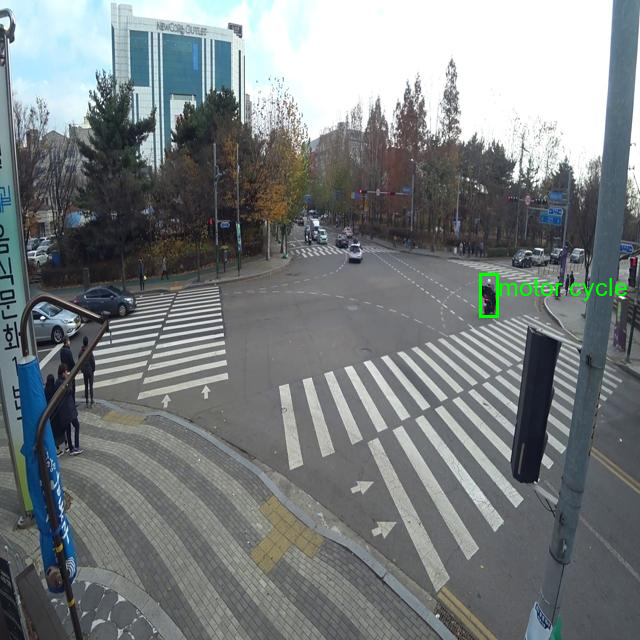

In [48]:
from PIL import Image, ImageDraw, ImageFont
import cv2
import random

# 랜덤 검수
i = random.randint(0, len(glob.glob(save_img_path + '/*')))

img_path = glob.glob(save_img_path + '/*')[i]
label_path = glob.glob(save_label_path+ '/*')[i]

# 1개의 객체만 bbox확인
IF = open(label_path, 'r')
line = IF.readline()
annotation = line.split()
IF.close()

if annotation[0] == '0':
    c = 'motor cycle'
elif annotation[0] == '1':
    c = 'bicycle'
else:
    c = 'kick board'
x = float(annotation[1]) * 640
y = float(annotation[2]) * 640
w = float(annotation[3]) * 640
h = float(annotation[4]) * 640

# arguments
color = (0,255,0)
text_pos = (int(x + w/2), int(y - h/2))
font_size = 25
font = ImageFont.truetype("arial.ttf", font_size) # arial.ttf 글씨체, font_size=15

# image
img = Image.open(img_path).convert('RGB')
draw = ImageDraw.Draw(img)
draw.rectangle( (int(x - w/2), int(y+h/2), int(x + w/2), int(y - h/2)), outline=color, width = 3) # 좌상단, 우하단 좌표
draw.text(text_pos, c, color, font=font) 
img

왜인지 모르지만 멀티 프로세싱 안됨...

In [ ]:
# import time, os
# from multiprocessing import Pool
# import multiprocessing
# import itertools

# start_time=time.time()
# processes = 2
# img_path = 'C:/Users/5788j/Desktop/custom_data/custom/dataset/원천데이터'
# label_path = 'C:/Users/5788j/Desktop/custom_data/custom/dataset/라벨링데이터' 
# save_img_path = 'C:/Users/5788j/Desktop/custom_data/custom/train/images/'
# save_label_path = 'C:/Users/5788j/Desktop/custom_data/custom/train/labels/'

# imgs = glob.glob(img_path + '/*')
# labels = glob.glob(label_path + '/*')

# args_list=[]
# for i,(img_path, label_path) in enumerate(zip(imgs, labels)):
#     args_list.append([i, img_path, label_path, save_img_path, save_label_path])
# print('컨버팅 준비 완료')

# if __name__=="__main__":
#     pool = multiprocessing.Pool(processes = processes)
#     pool.starmap( testLogic, args_list ) # 각 코어에 입력값들을 병렬 처리

#     pool.close() # 멀티 프로세싱 종료
#     pool.join()
#     print("--- %s seconds ---" % (time.time() - start_time))

컨버팅 준비 완료
